# Exploratory Data Analysis
### DATA301 | Group 3

Initial transformations on the **police** dataset and **employment** datasets are performed in `data_wrangling_data301.ipynb`. Running this notebook generates the files `police_dataset_clean.csv` and `employment_dataset_clean.csv` in the `/output` directory.

The police dataset contains detailed anonymized information about crime victimisations from 2014 to 2025. This can be accessed here: https://public.tableau.com/app/profile/policedata.nz/viz/VictimisationsPoliceStations/Summary. More details on how to run the data wrangling notebook are provided within the notebook. The employment dataset was required as one of the group members is analysing how employment rate is related to crime victimizations. The primary purpose of the `data_wrangling_data301.ipynb` notebook was to get these datasets in a format which can be joined.

## EDA Introduction

Data wrangling has already been performed to transform the police dataset to a suitable format for exploratory data analysis. The police dataset in its raw state was reasonably tidy, and the main data wrangling task was down-sampling the `Year Month` column from monthly to quarterly frequency. This was required as one of the group members' individual questions related to unemployment rates, and the unemployment reporting with the highest frequency from stats NZ is quarterly. We determined that interpolation was not appropriate as monthly frequency would require two extra datapoints to be inferred between each of the adjacent quarterly values. This may miss nuances in the trend, and complicate any modelling performed in subsequent steps of the project. The data-wrangling notebook can be found here: https://github.com/LennoxC/data301-group3-project/blob/main/data_wrangling_data301_eda.ipynb. Overall the police and employment datasets required minimal transformations and wrangling to be converted to a suitable format.



In [222]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dataframe_image as dfi

In [223]:
# charts and tables will be saved to the `/images` directory
IMAGE_PATH = "images"

# call this when saving a figure to generate a file name
def get_output_path(figure_name):
    return os.path.join(IMAGE_PATH, figure_name)

# ensure the images directory exists
os.makedirs(IMAGE_PATH, exist_ok=True)

In [224]:
# load the datasets
police = pd.read_csv("output/police_dataset_clean.csv")
employment = pd.read_csv("output/employment_dataset_clean.csv")

C:\Users\lenno\AppData\Local\Temp\ipykernel_14456\1845274278.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  police = pd.read_csv("output/police_dataset_clean.csv")


### Initial Understanding of the Dataframes

The police dataset has the following structure:

In [225]:
police.head()

,Unnamed: 0,Anzsoc Division,Police Area/TA,Police District/TA,Police Station/TA,Location Type Description,Location Type Division,Person/Organisation,Weapons Used,Year Month,...,Police Boundary,Previous Period,Selected Period,Table 1,Variance,Weapon,year,quarter,quarter_start,Police District Merged
0,0,Burglary,Auckland Central Area,Auckland City,Auckland Central,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
1,1,Burglary,Auckland East Area,Auckland City,Glen Innes,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
2,2,Burglary,Auckland East Area,Auckland City,Newmarket,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
3,3,Burglary,Auckland West Area,Auckland City,Ponsonby,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
4,4,Burglary,Auckland Central Area,Auckland City,Auckland Central,Public Place,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland


In [226]:
df_police_head = pd.DataFrame(police.dtypes)

In [227]:
dfi.export(df_police_head, get_output_path("police_head.png"), table_conversion='matplotlib')

The police dataset is in long format. To find a trend of victimisations, the dataset will need to be grouped by an appropriate datatime column. This is a flexible way to store the dataframe, because it allows victimisation reporting across any of the other features of the dataframe. For example, to visualise victims of crimes involving different types of weapons, the dataframe should be grouped by 'month' and 'weapons used'.

The employment dataset has the following structure:

In [228]:
employment.head()

,Unnamed: 0,quarter_start,year,quarter,Period,Auckland,Bay Of Plenty,Canterbury,Eastern,Northland,Tasman,Total All Regional Councils,Waikato,Wellington
0,0,1986-01-01,1986,1,1986.03,66.10,61.7,64.0,64.40,59.80,61.20,64.30,63.60,67.30
1,1,1986-04-01,1986,2,1986.06,66.40,61.1,63.9,63.20,56.60,59.10,63.90,63.10,67.20
2,2,1986-07-01,1986,3,1986.09,67.20,60.2,62.8,58.90,57.60,62.30,63.60,62.30,66.40
3,3,1986-10-01,1986,4,1986.12,66.85,61.7,61.9,61.50,58.00,61.75,63.90,62.85,67.85
4,4,1987-01-01,1987,1,1987.03,67.20,61.3,61.5,61.85,58.05,62.15,63.85,63.10,67.30


In [229]:
df_employment_head = pd.DataFrame(employment.dtypes)
dfi.export(df_employment_head, get_output_path("employment_head.png"), table_conversion='matplotlib')

The employment dataset is already aggregated by quarter, and reports an employment statistic for all 10 regional council areas, along with a 'total' (nation-wide). The value being measured is the **percentage of the estimated working-age population who are employed**.

In [230]:
police['quarter_start'] = pd.to_datetime(police['quarter_start'])
employment['quarter_start'] = pd.to_datetime(employment['quarter_start'])

### Check for missing values

Most statistical models require a complete dataset with no missing values. The police and employment datasets should be queried for missing values.

In [231]:
police.notnull().sum()

Unnamed: 0                   1463366
Anzsoc Division              1463366
Police Area/TA               1463366
Police District/TA           1463366
Police Station/TA            1463366
Location Type Description    1463366
Location Type Division       1463366
Person/Organisation          1463366
Weapons Used                 1223500
Year Month                   1463366
Police Area                  1463366
Police District              1463366
Police Station               1463366
Territorial Authority        1463366
Victimisations               1463366
% Variance                    164419
%Variance                    1463362
Age Group                    1463366
Anzsoc Group                 1463366
Anzsoc Subdivision           1463366
Anzsoc Subgroup              1463366
Ethnic Group                 1463366
Ethnicity                    1463366
Location                     1463366
Location Type                1463366
Number of Records            1463366
Police   Boundary            1463366
P

In [232]:
employment.notnull().sum()

Unnamed: 0                     157
quarter_start                  157
year                           157
quarter                        157
Period                         157
Auckland                       157
Bay Of Plenty                  157
Canterbury                     157
Eastern                        157
Northland                      157
Tasman                         157
Total All Regional Councils    157
Waikato                        157
Wellington                     157
dtype: int64

In [233]:
df_police_missing = pd.DataFrame(police.notnull().sum())
dfi.export(df_police_missing, get_output_path("police_missing.png"), table_conversion='matplotlib')

df_employment_missing = pd.DataFrame(employment.notnull().sum())
dfi.export(df_employment_missing, get_output_path("employment_missing.png"), table_conversion='matplotlib')

The employment dataset does not contain any null values.

The police dataset contains null values in the following columns:
- `Weapons used`
- `% Variance` (and another column called `%Variance`)
- `Weapon`

In [234]:
police['Weapon'].value_counts()

Weapon
Not Applicable             940449
Not Stated                 216883
Other Weapon                26499
Blunt Instrument N.F.D.     16993
Sharp N.F.D.                10176
Firearm N.F.D.               4510
Knife                        2898
Blunt Instrument N.E.C.      2184
Sharp N.E.C.                  875
Bludgeon                      618
Handgun                       441
Shotgun                       407
Rifle                         207
Bottle/Glass                  160
Air Gun                        94
Firearm N.E.C.                 72
Replica Firearm                34
Name: count, dtype: int64

In [235]:
police['Weapons Used'].value_counts()

Weapons Used
Not Applicable             940449
Not Stated                 216883
Other Weapon                26499
Blunt Instrument            17611
Stabbing/Cutting Weapon     14109
Firearms                     5765
Blunt Instrument N.E.C.      2184
Name: count, dtype: int64

In [236]:
police[police['Weapons Used'].isnull()][['Weapon', 'Weapons Used']].head()

,Weapon,Weapons Used
119,NaN,NaN
120,NaN,NaN
121,NaN,NaN
122,NaN,NaN
123,NaN,NaN


In [237]:
df_police_missing_nan = pd.DataFrame(police[police['Weapons Used'].isnull()][['Weapon', 'Weapons Used']].head())
dfi.export(df_police_missing_nan, get_output_path("police_missing_nan.png"), table_conversion='matplotlib')

#### Handling the missing values

##### Weapons

There are five rows in the police dataset which contain missing values for both `Weapon` and `Weapons Used`. The null values for each column are the same set of records, so there are only five rows with missing values.

It is unclear if these can be safely re-labelled to 'not applicable', so these records can be dropped.

##### Variance

The variance column is not necessary for the questions being answered by the group, so can be dropped. Therefore no records will be lost due to the null values in these columns.

In [238]:
police = police.drop(columns=['% Variance', '%Variance'])

In [239]:
police = police.dropna()

In [240]:
len(police)

1223500

## Summary Tables and Plots

In [241]:
police.head()

,Unnamed: 0,Anzsoc Division,Police Area/TA,Police District/TA,Police Station/TA,Location Type Description,Location Type Division,Person/Organisation,Weapons Used,Year Month,...,Police Boundary,Previous Period,Selected Period,Table 1,Variance,Weapon,year,quarter,quarter_start,Police District Merged
0,0,Burglary,Auckland Central Area,Auckland City,Auckland Central,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
1,1,Burglary,Auckland East Area,Auckland City,Glen Innes,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
2,2,Burglary,Auckland East Area,Auckland City,Newmarket,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
3,3,Burglary,Auckland West Area,Auckland City,Ponsonby,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
4,4,Burglary,Auckland Central Area,Auckland City,Auckland Central,Public Place,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland


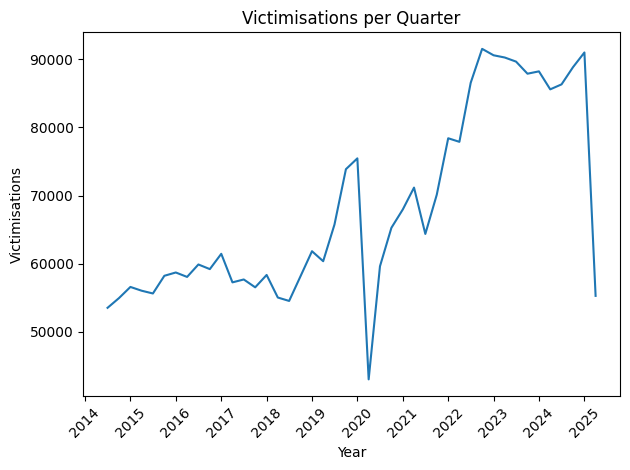

In [242]:
crime_by_quarter = police['Victimisations'].groupby(police['quarter_start']).sum()

fig, ax = plt.subplots()
ax.plot(crime_by_quarter.index, crime_by_quarter.values)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

title = "Victimisations per Quarter"

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")
plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

The number of crime victimisations since 2014 follows an interesting trend. Initially, from 2014-2020, the number of victimisations remained reasonably constant...

## Seasonality for Police

In [243]:
from statsmodels.tsa.seasonal import STL

crime_by_month = police.groupby("Year Month")["Victimisations"].sum().reset_index()
crime_by_month["Year Month"] = pd.to_datetime(crime_by_month["Year Month"])

crime_by_month = crime_by_month.set_index("Year Month").asfreq("MS")

stl = STL(crime_by_month["Victimisations"], period=12, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

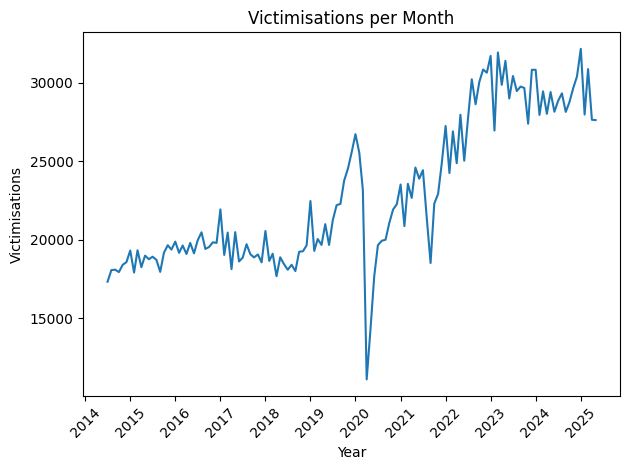

In [244]:
crime_by_month = police.groupby("Year Month")["Victimisations"].sum().reset_index()
crime_by_month["Year Month"] = pd.to_datetime(crime_by_month["Year Month"])

fig, ax = plt.subplots()
ax.plot(crime_by_month["Year Month"], crime_by_month["Victimisations"])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")

title = "Victimisations per Month"

plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

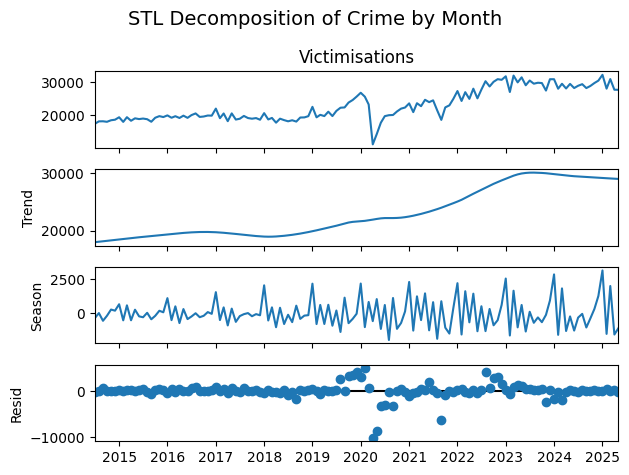

In [245]:
fig = result.plot()

title = "STL Decomposition of Crime by Month"

plt.suptitle(title, fontsize=14)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

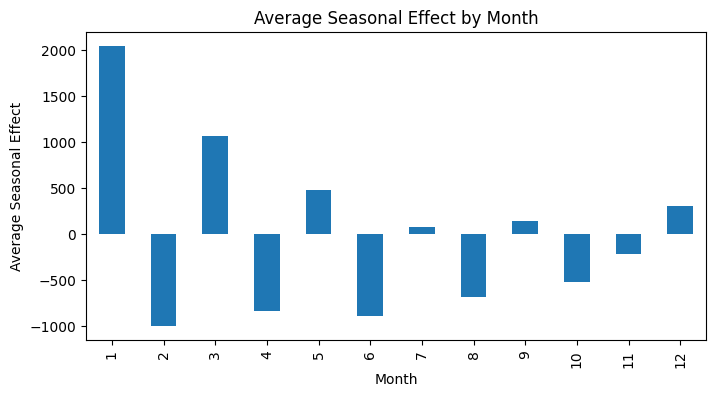

In [246]:
seasonal = result.seasonal
seasonal_by_month = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(8,4))
seasonal_by_month.plot(kind="bar")

title = "Average Seasonal Effect by Month"

plt.title(title)
plt.xlabel("Month")
plt.ylabel("Average Seasonal Effect")

plt.savefig(get_output_path(title + ".png"))

plt.show()

# Employment

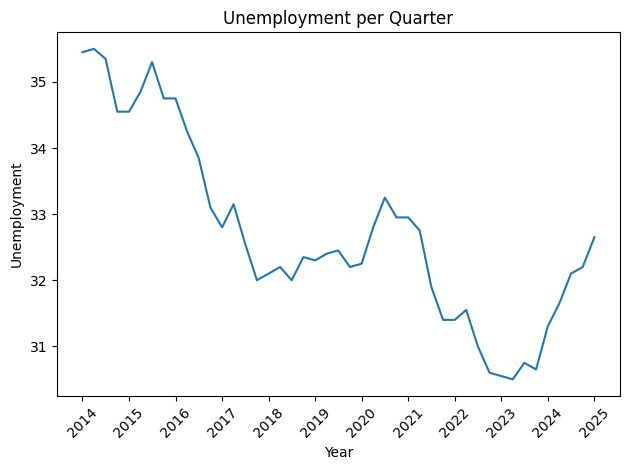

In [247]:
employment_post_2014 = employment[employment['year'] >= 2014]
employment_by_quarter = employment_post_2014[['quarter_start', 'Total All Regional Councils']]

unemployment = 100 - np.array(employment_by_quarter['Total All Regional Councils'])

fig, ax = plt.subplots()
ax.plot(employment_by_quarter['quarter_start'], unemployment)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Unemployment")

title = "Unemployment per Quarter"

plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

## Regional Breakdown

In [248]:
crime_by_quarter_regional = pd.DataFrame(police.groupby(['quarter_start', 'Police District Merged'])['Victimisations'].sum())

crime_by_quarter_regional_wide = (
    crime_by_quarter_regional
    .pivot_table(
        index=["quarter_start"],  # time-related columns
        columns="Police District Merged",
        values="Victimisations"
    )
    .reset_index()
    .sort_values("quarter_start")
)

crime_by_quarter_regional_wide["quarter_start"] = pd.to_datetime(crime_by_quarter_regional_wide["quarter_start"])

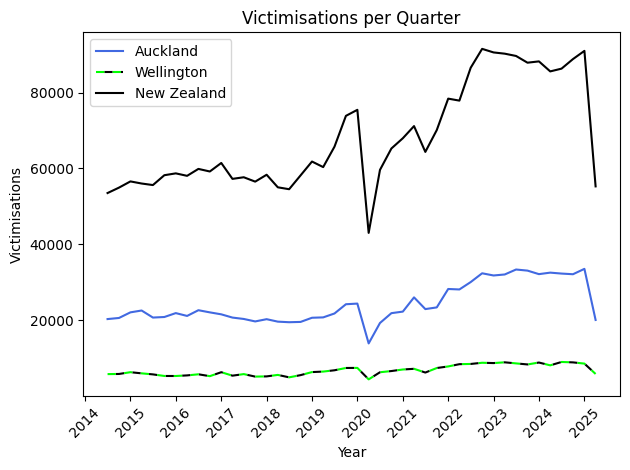

In [249]:
fig, ax = plt.subplots()
ax.plot(crime_by_quarter_regional_wide["quarter_start"], crime_by_quarter_regional_wide["Auckland"], label="Auckland", c="royalblue")
ax.plot(crime_by_quarter_regional_wide["quarter_start"], crime_by_quarter_regional_wide["Wellington"], label="Wellington", c="lime", dashes=[4, 4], gapcolor='black')
ax.plot(crime_by_quarter.index, crime_by_quarter.values, label="New Zealand", c="black")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")

title = "Victimisations per Quarter"

plt.title(title)
plt.legend()
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

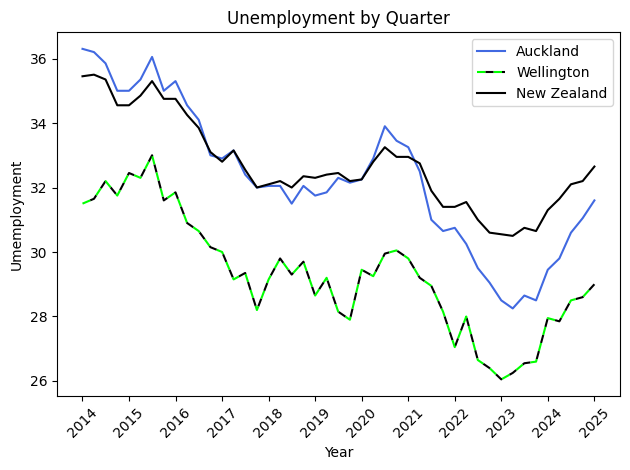

In [250]:
employment_post_2014 = employment[employment['year'] >= 2014]

fig, ax = plt.subplots()
ax.plot(employment_post_2014["quarter_start"], 100 - np.array(employment_post_2014['Auckland']), label="Auckland", c="royalblue")
ax.plot(employment_post_2014["quarter_start"], 100 - np.array(employment_post_2014["Wellington"]), label="Wellington", c="lime", dashes=[4, 4], gapcolor='black')
ax.plot(employment_post_2014['quarter_start'], 100 - np.array(employment_post_2014['Total All Regional Councils']), label="New Zealand", c="Black")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Umemployment")

title = "Unemployment by Quarter"

plt.title(title)
plt.legend()
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()